In [1]:
!pip install -U lightautoml
!pip install flaml[automl] matplotlib openml
!pip install -U ipywidgets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.0/399.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.0/216.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.5 MB/s eta 0:00:00
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7

# Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from flaml import AutoML
import json

from flaml.automl.model import LGBMEstimator

import joblib

# Load data

In [ ]:
calendar_df = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/calendar.csv')
inventory_df = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/inventory.csv')
train_df = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_train.csv')
test_df = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_test.csv')
df5 = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/solution.csv')
weights_df = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/test_weights.csv')

In [3]:
df5

,id,sales_hat
0,1226_2024-06-03,0
1,1226_2024-06-11,0
2,1226_2024-06-13,0
3,1226_2024-06-15,0
4,1226_2024-06-09,0
...,...,...
47016,4572_2024-06-03,0
47017,3735_2024-06-04,0
47018,3735_2024-06-03,0
47019,2129_2024-06-03,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007419 entries, 0 to 4007418
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   unique_id        int64  
 1   date             object 
 2   warehouse        object 
 3   total_orders     float64
 4   sales            float64
 5   sell_price_main  float64
 6   availability     float64
 7   type_0_discount  float64
 8   type_1_discount  float64
 9   type_2_discount  float64
 10  type_3_discount  float64
 11  type_4_discount  float64
 12  type_5_discount  float64
 13  type_6_discount  float64
dtypes: float64(11), int64(1), object(2)
memory usage: 428.0+ MB


In [5]:
test_columns = list(test_df.columns)
keep_columns =  list(train_df.columns)
print(test_columns)
keep_columns 

['unique_id', 'date', 'warehouse', 'total_orders', 'sell_price_main', 'type_0_discount', 'type_1_discount', 'type_2_discount', 'type_3_discount', 'type_4_discount', 'type_5_discount', 'type_6_discount']


['unique_id',
 'date',
 'warehouse',
 'total_orders',
 'sales',
 'sell_price_main',
 'availability',
 'type_0_discount',
 'type_1_discount',
 'type_2_discount',
 'type_3_discount',
 'type_4_discount',
 'type_5_discount',
 'type_6_discount']

# EDA

### Ta vẽ biểu đồ xem tổng doanh thu theo thời gian

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


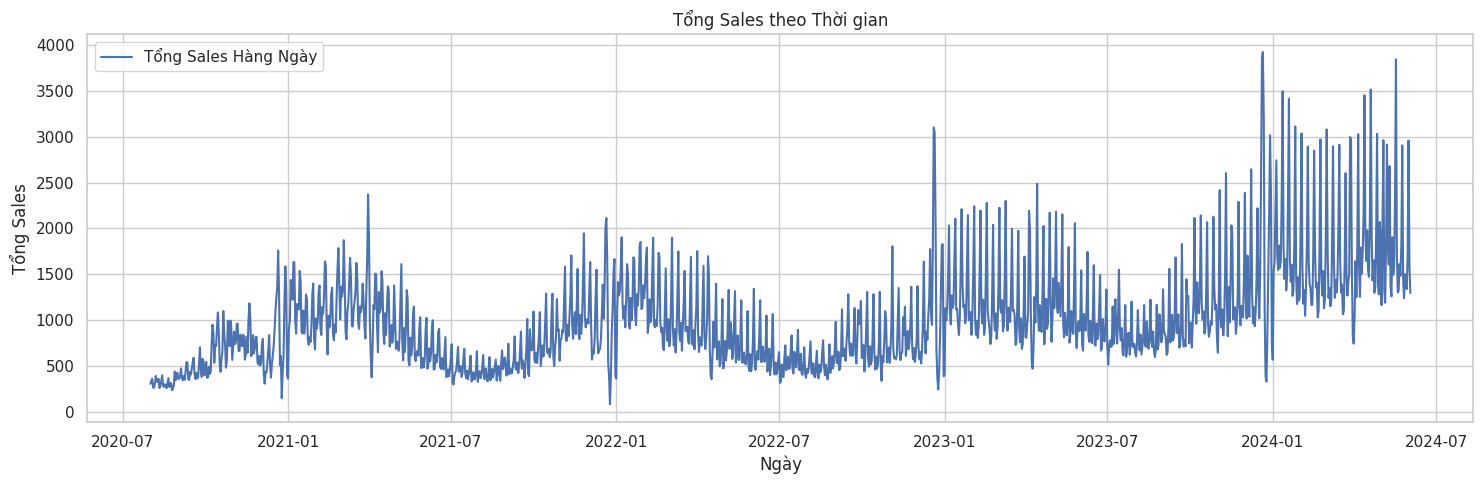

In [8]:
# Chuyển cột date về định dạng datetime
train_df['date'] = pd.to_datetime(train_df['date'], errors='coerce')

# Lọc các giá trị sales >= 0
train_df_copy = train_df[train_df['sales'] >= 0]

# Tổng hợp sales theo ngày
daily_sales = train_df_copy.groupby('date')['sales'].sum().reset_index()

# Thiết lập kiểu hiển thị
sns.set(style="whitegrid")

# Vẽ biểu đồ đường
plt.figure(figsize=(15, 5))
sns.lineplot(data=daily_sales, x='date', y='sales', label='Tổng Sales Hàng Ngày')

plt.title("Tổng Sales theo Thời gian")
plt.xlabel("Ngày")
plt.ylabel("Tổng Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Có thể thấy rằng từ 2020–2022 doanh thu dao động 500–2000 USD, không tăng trưởng rõ rệt do gián đoạn bởi đại dịch COVID-19.
- Từ 2023 trở đi, doanh thu tăng tuyến tính, phản ánh sự phục hồi thị trường và gia tăng nhu cầu.
- Ngày 1/1 hằng năm: Doanh thu gần như bằng 0 do nghỉ lễ Tết, hoạt động bán hàng bị hạn chế.

### Tiếp theo, ta xem phân phối dữ liệu của cột `sales`

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


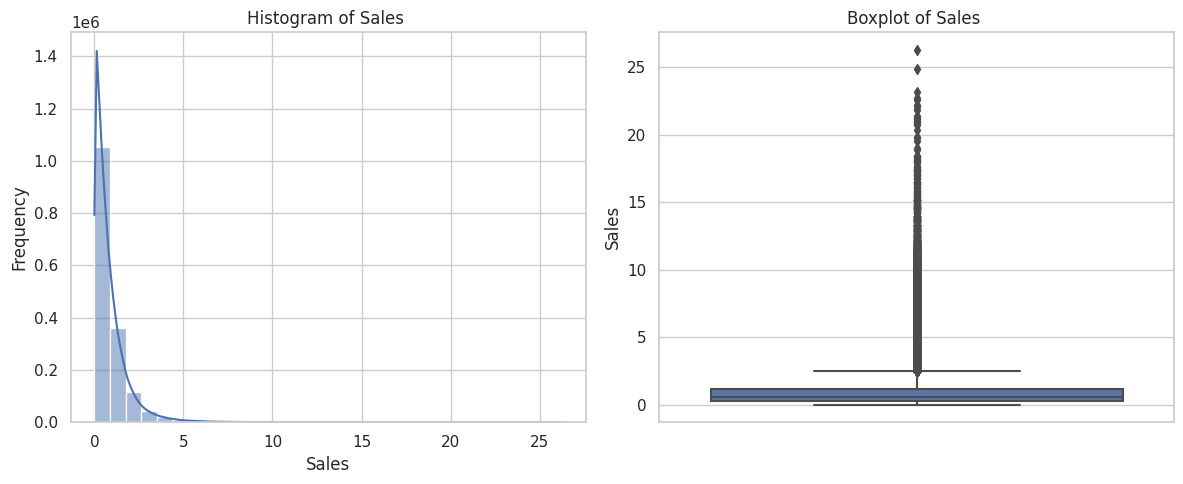

In [9]:
# Thiết lập kiểu hiển thị cho Seaborn
sns.set(style="whitegrid")

# Lọc bỏ các giá trị âm trong cột sales
filtered_df = train_df[train_df["sales"] >= 0]

# Tạo figure với 2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Vẽ histogram
sns.histplot(data=filtered_df, x="sales", bins=30, kde=True, ax=ax1)
ax1.set_title("Histogram of Sales ")
ax1.set_xlabel("Sales")
ax1.set_ylabel("Frequency")

# Vẽ boxplot
sns.boxplot(data=filtered_df, y="sales", ax=ax2)
ax2.set_title("Boxplot of Sales ")
ax2.set_ylabel("Sales")

# Điều chỉnh layout để tránh chồng lấn
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

- Nhìn vào histogram, có thể thấy dữ liệu bị lệch phải, tập trung gần 0 → phần lớn sản phẩm bán ít.
- Boxplot: Nhiều outliers => tồn tại các đơn hàng có giá trị cao bất thường, phân phối dữ liệu không đồng đều.

### Tiếp theo, ta phân tích phân bố trung bình ngày nghỉ theo tháng của từng kho

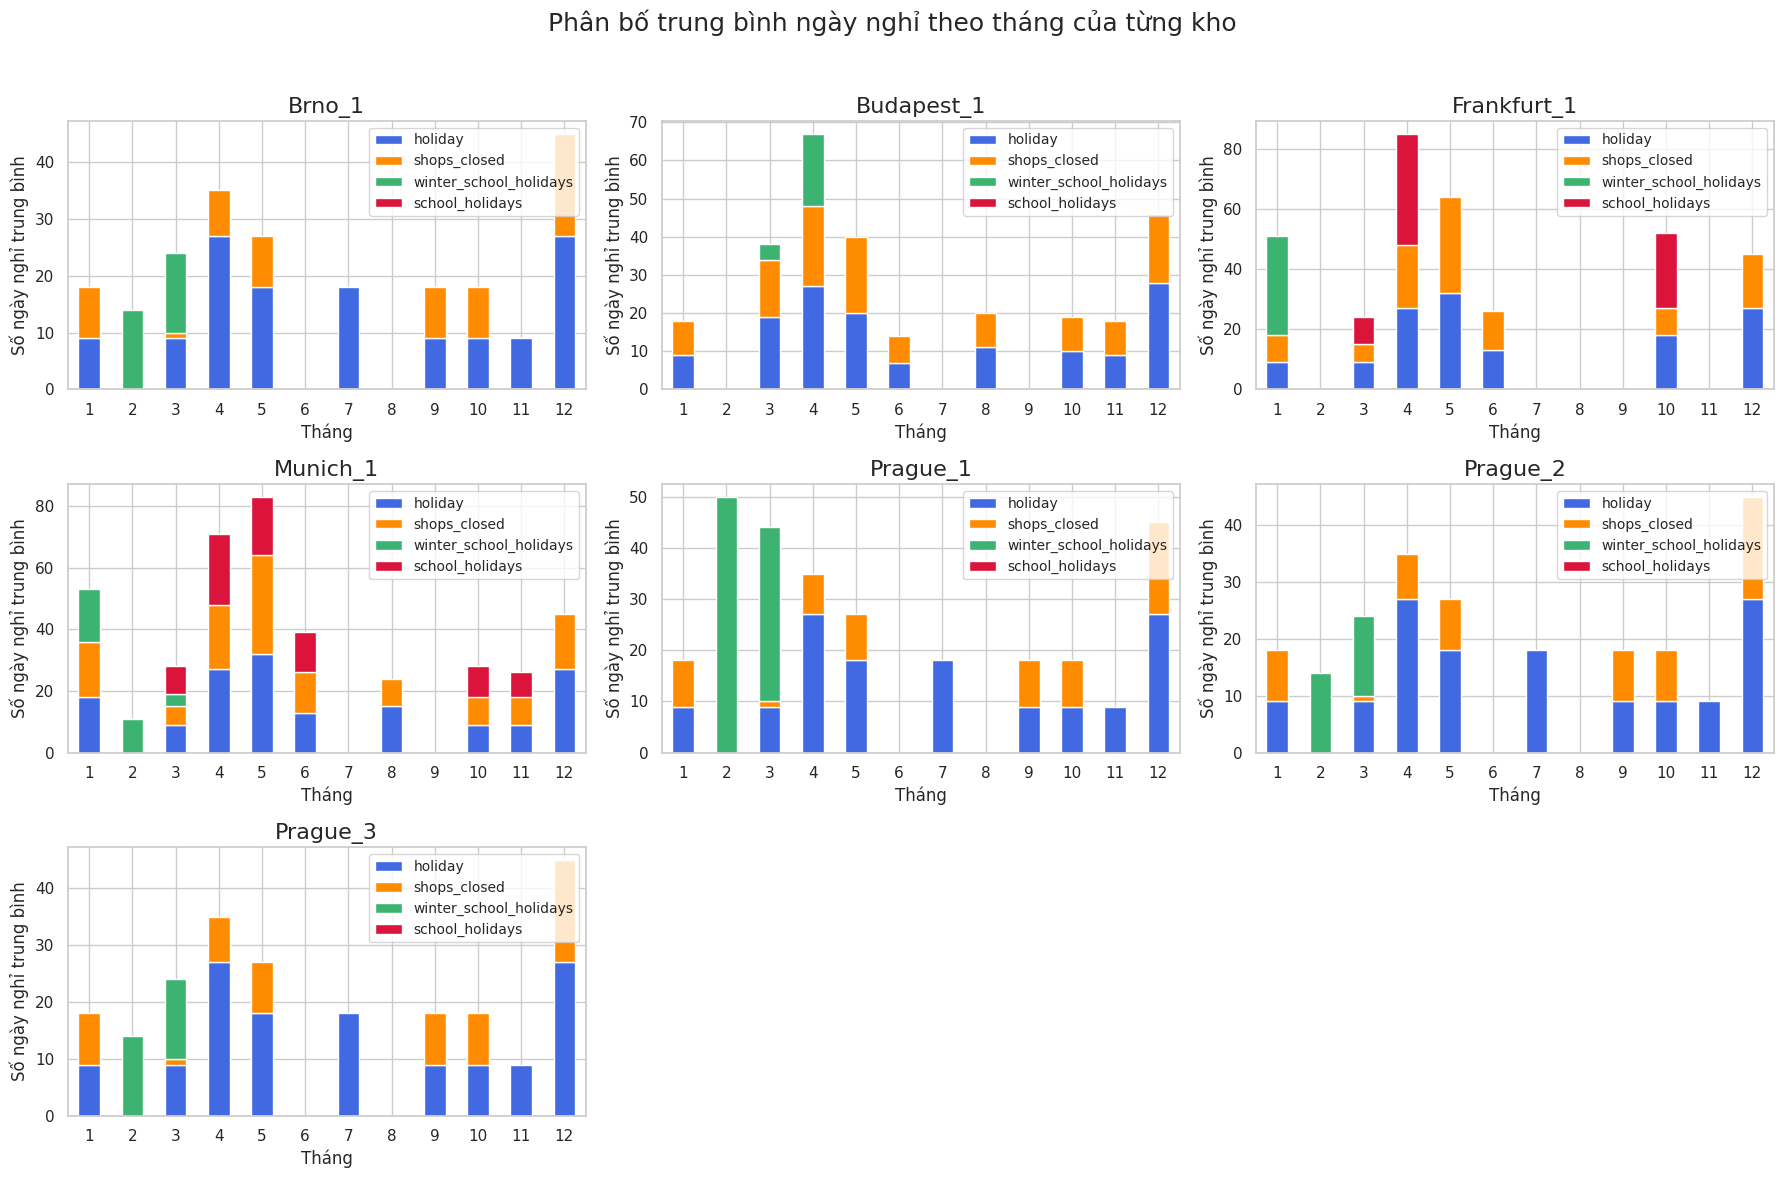

In [10]:
# Chuyển date sang datetime nếu chưa làm
calendar_df['date'] = pd.to_datetime(calendar_df['date'], errors='coerce')

# Thêm cột tháng
calendar_df['month_n'] = calendar_df['date'].dt.month

# Danh sách các cột cần tính trung bình
holiday_cols = ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']

# Tính trung bình số ngày nghỉ theo kho và tháng
grouped_df = calendar_df.groupby(['warehouse', 'month_n'])[holiday_cols].sum().reset_index()

# Danh sách các kho
warehouses = grouped_df['warehouse'].unique()

# Thiết lập biểu đồ lưới
rows = (len(warehouses) + 2) // 3
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(18, rows * 4))
axes = axes.flatten()

# Màu cho từng loại ngày nghỉ
colors = ['royalblue', 'darkorange', 'mediumseagreen', 'crimson']

# Vẽ từng warehouse
for i, warehouse in enumerate(warehouses):
    data = grouped_df[grouped_df['warehouse'] == warehouse].set_index('month_n')
    data = data[holiday_cols]

    data.plot(kind='bar', stacked=True, ax=axes[i], color=colors)
    axes[i].set_title(f'{warehouse}', fontsize=16)
    axes[i].set_xlabel('Tháng')
    axes[i].set_ylabel('Số ngày nghỉ trung bình')
    axes[i].legend(loc='upper right', fontsize=10)
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].set_xticks(range(0, 12))
    axes[i].set_xticklabels(range(1, 13))

# Xoá subplot thừa nếu có
for j in range(len(warehouses), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Phân bố trung bình ngày nghỉ theo tháng của từng kho", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Biến `holiday` thể hiện số ngày nghỉ trong năm và có tác động rõ rệt đến hoạt động kinh doanh, qua việc phân tích biểu đồ ta có thể thấy rằng:
- Tháng 4 – 5 ghi nhận số lượng ngày nghỉ cao nhất, đặc biệt tại các địa điểm như Munich_1, Frankfurt_1 và Brno_1. Điều này có thể liên quan đến các dịp lễ lớn ở châu Âu như Lễ Phục sinh, Ngày Quốc tế Lao động,... làm ảnh hưởng đến thời gian hoạt động và doanh thu.
- Tháng 7 – 8 lại có số ngày nghỉ thấp hơn, đây cũng là khoảng thời gian thuận lợi cho việc kinh doanh vì các cửa hàng mở bán đều đặn hơn và nhu cầu tiêu dùng vẫn ở mức tốt.
- Tháng 1 – 3 và tháng 12 cũng có khá nhiều ngày nghỉ do rơi vào dịp lễ Tết Dương lịch, Giáng sinh và kỳ nghỉ đông – các yếu tố có thể vừa làm giảm số ngày mở bán, vừa thúc đẩy sức mua trong những giai đoạn cao điểm.

=> Hầu hết các tháng trong năm đều có ít nhất một vài ngày nghỉ, cho thấy rằng biến `holiday` có tác động đa chiều đến doanh thu.

### Tiếp theo, ta xem phân phối dữ liệu của các kho hàng

In [13]:
train_df['warehouse'].value_counts()

warehouse
Prague_1       780566
Prague_3       779655
Prague_2       770709
Brno_1         643637
Budapest_1     574582
Munich_1       259333
Frankfurt_1    198937
Name: count, dtype: int64

`warehouse` cho thấy dữ liệu phân bố không đều giữa các kho. Ba kho ở Prague (Prague_1, Prague_3, Prague_2) chiếm tỷ trọng lớn nhất với tổng cộng hơn 2,3 triệu bản ghi. Các kho như Frankfurt_1 và Munich_1 có số lượng mẫu thấp hơn đáng kể. Điều này phản ánh sự mất cân bằng trong dữ liệu giữa các kho
### Để xem tổng thể về hiệu quả vận hành và sức mua tại các khu vực, ta phân tích doanh thu theo từng kho

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


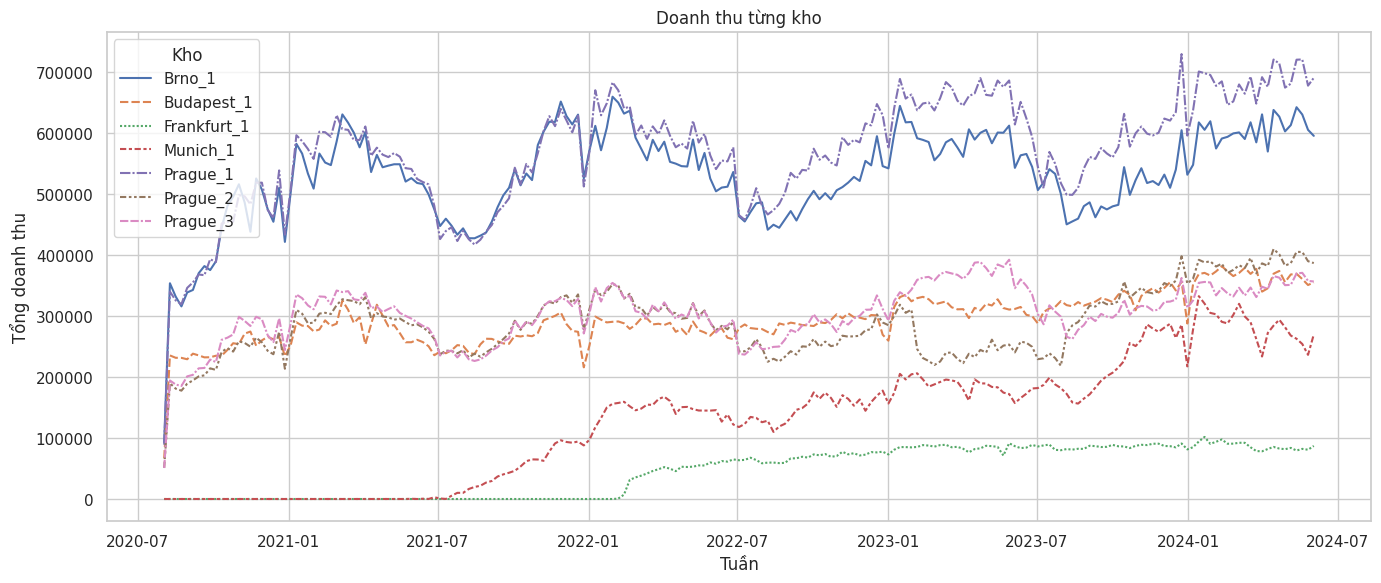

In [11]:
# Đọc dữ liệu
df = pd.read_csv('/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_train.csv', parse_dates=['date'])

# Tạo cột tháng và năm
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Nếu date chưa là datetime
df['date'] = pd.to_datetime(df['date'])

# Nhóm theo ngày và kho, tính tổng doanh thu
daily_sales = df.groupby(['date', 'warehouse'])['sales'].sum().reset_index()

# Tổng hợp theo tuần (resample tuần, có thể đổi thành 'M' nếu muốn theo tháng)
# Pivot để tạo bảng cho plotting dễ
pivot_table = daily_sales.pivot(index='date', columns='warehouse', values='sales')
pivot_table_week = pivot_table.resample('W').sum()

plt.figure(figsize=(14, 6))
sns.lineplot(data=pivot_table_week)
plt.title('Doanh thu từng kho')
plt.xlabel('Tuần')
plt.ylabel('Tổng doanh thu')
plt.legend(title='Kho')
plt.tight_layout()
plt.show()

- Nhìn chung, doanh thu có xu hướng tăng trưởng ổn định theo thời gian tại hầu hết các kho
- `Brno_1` và `Prague_1` nổi bật với mức doanh thu cao vượt trội. Đây có thể là kết quả của nhu cầu tiêu dùng mạnh mẽ, quy mô thị trường lớn. 
- Ngược lại, Frankfurt_1 thể hiện hiệu suất thấp hơn đáng kể so với các kho khác. Có thể do quy mô thị trường nhỏ, giai đoạn triển khai chậm hơn, hoặc các vấn đề nội bộ liên quan đến logistics và chuỗi cung ứng.
- Ngoài ra, có một giai đoạn sụt giảm doanh thu ngắn hạn vào khoảng năm 2021–2023, phù hợp với bối cảnh đại dịch COVID-19. Trong thời gian này, nhiều hoạt động kinh doanh bị gián đoạn, nguồn cung và sức mua đều bị ảnh hưởng, thể hiện rõ trong số liệu doanh thu.
### Tiếp theo, ta xem phân phối của cột `total_orders`

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


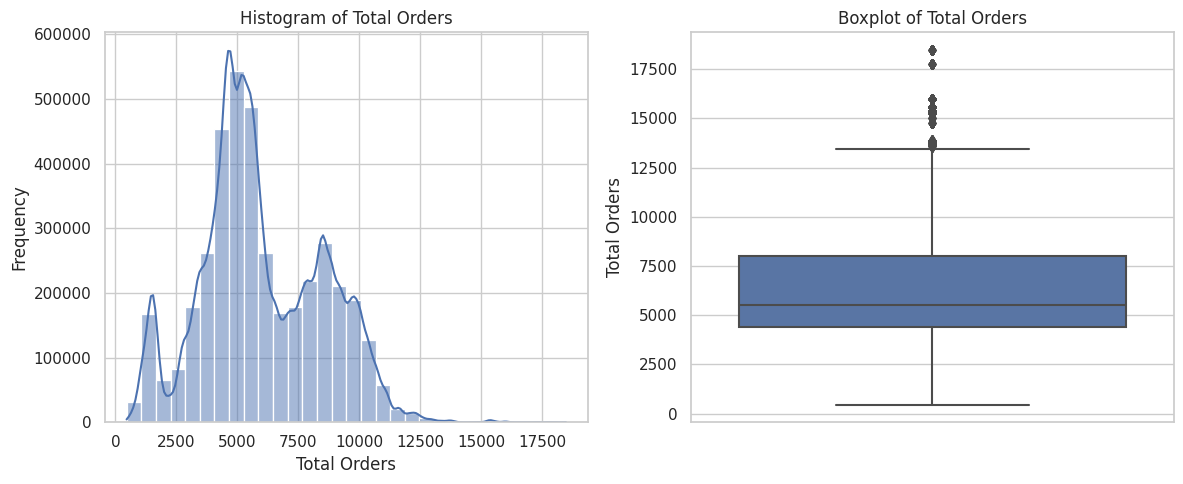

In [12]:
# Thiết lập kiểu hiển thị
sns.set(style="whitegrid")

# Tạo figure với 2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Vẽ histogram
sns.histplot(data=train_df, x="total_orders", bins=30, kde=True, ax=ax1)
ax1.set_title("Histogram of Total Orders")
ax1.set_xlabel("Total Orders")
ax1.set_ylabel("Frequency")

# Vẽ boxplot
sns.boxplot(data=train_df, y="total_orders", ax=ax2)
ax2.set_title("Boxplot of Total Orders")
ax2.set_ylabel("Total Orders")

# Điều chỉnh layout
plt.tight_layout()
plt.show()

Nhận xét:
- Histogram: Dữ liệu lệch phải, tập trung 3.000 – 7.000 đơn, đuôi dài đến > 17.000.
- Boxplot: Đa số nằm trong 3.000–10.000, rất nhiều outliers > 13.000, cho thấy rằng dữ liệu có độ phân tán cao, cần được xử lý.

### Tiếp theo, ta phân tích các loại giảm giá đang được Rohlik áp dụng

In [6]:
for i in range(7):
    col = f'type_{i}_discount'
    print(f'{col}: min = {min(train_df[col])}, max = {max(train_df[col])}')

type_0_discount: min = -20.9493, max = 0.99164
type_1_discount: min = 0.0, max = 0.5
type_2_discount: min = 0.0, max = 0.76372
type_3_discount: min = 0.0, max = 0.25063
type_4_discount: min = -0.04712, max = 0.4529
type_5_discount: min = 0.0, max = 0.66914
type_6_discount: min = -0.80149, max = 0.90005


Có thể thấy một số loại giảm giá có giá trị âm bất thường, cần được xử lí
### Cuối cùng, ta quan sát ma trận tương quan của các cột dữ liệu


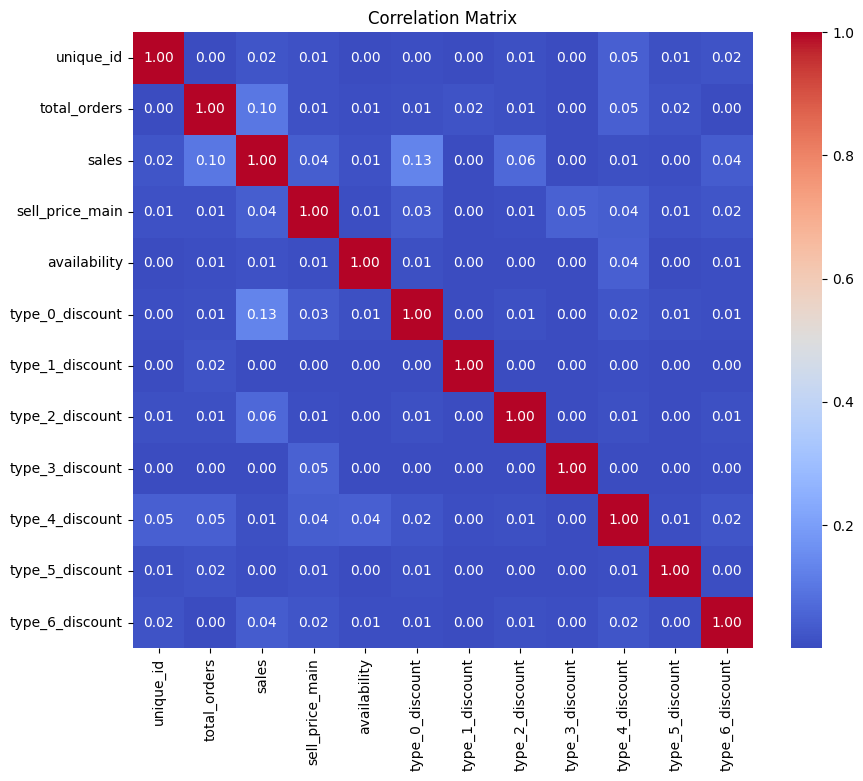

In [9]:
corr_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(abs(corr_matrix), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Phân tích ma trận tương quan cho thấy phần lớn các biến không có mối tương quan tuyến tính mạnh với nhau. Biến `sales` có tương quan nhẹ với `total_orders` và `type_0_discount`, cho thấy hai yếu tố này có thể ảnh hưởng đến doanh số.